In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

from pathlib import Path

In [3]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_clean/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [7]:
path = Path('/home/dl/data/vrep/v2/')
path_noisy = path/'cam_1_tex' #h
path_clean = path/'cam_1_can' #l

In [8]:
bs,size=64,128
arch = models.resnet34
src = ImageImageList.from_folder(path_noisy).random_split_by_pct(0.1, seed=42)
data = get_data(bs,size)

In [11]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [13]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

NameError: name 'blocks' is not defined

In [14]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [15]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [16]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

In [23]:
from torchsummary import summary

In [59]:
encoder = nn.Sequential(*learn.model[:4])
# for layer in learn.model[:5]:
#     print(layer)
#     print('===')
#     break

In [60]:
encoder

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [55]:
summary(encoder, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [61]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

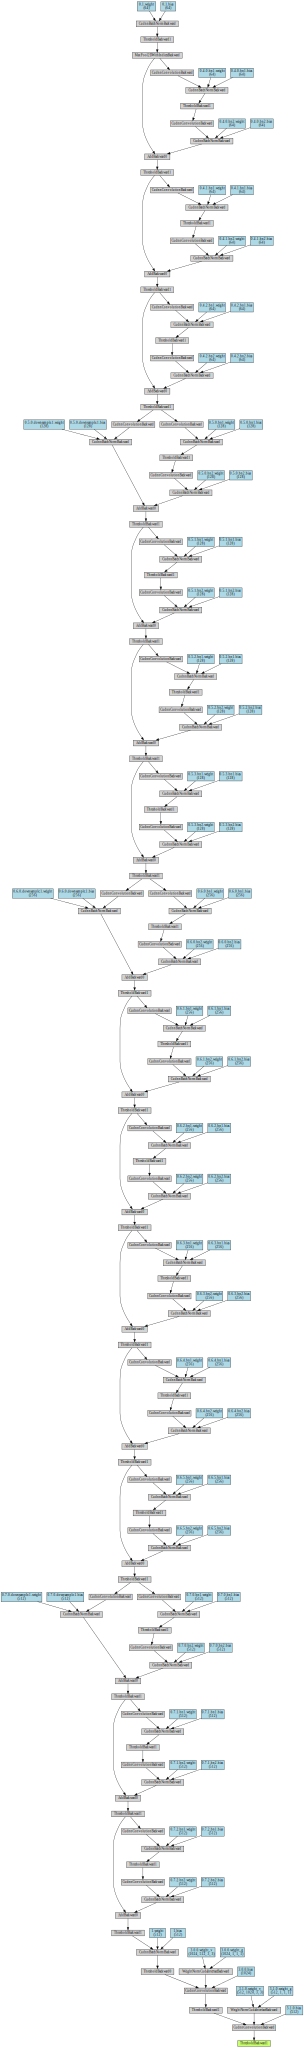

In [63]:
make_dot(encoder(torch.randn(1, 3, 128, 128).to(device)), params=dict(encoder.named_parameters()))

In [65]:
res = encoder(torch.randn(1, 3, 128, 128).to(device))

In [66]:
res.shape

torch.Size([1, 512, 4, 4])

In [128]:
import torchvision.models as models
net = models.squeezenet1_0(pretrained=True)

/home/dl/anaconda3/envs/fastai/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/dl/anaconda3/envs/fastai/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [130]:
_=net.to(device)

In [131]:
a = torch.randn(1, 3, 224, 224).to(device)

In [132]:
net(a)

tensor([[3.8900, 4.3447, 0.8647, 0.9475, 3.9939, 4.7409, 4.5169, 6.0487, 4.1048,
         3.3984, 1.2202, 2.4193, 1.7004, 1.9143, 4.0369, 3.7702, 1.1948, 4.7033,
         6.5576, 1.8975, 1.1037, 3.1495, 1.4911, 4.2212, 2.7740, 1.3039, 2.2415,
         3.3967, 1.5833, 1.3222, 4.1339, 3.4977, 2.1649, 1.4839, 2.5340, 2.9412,
         3.4808, 2.9188, 2.5402, 7.4968, 5.0729, 3.9720, 4.4870, 2.6553, 2.4817,
         3.3902, 6.3804, 4.7172, 5.5394, 2.5900, 4.9458, 1.2878, 2.1832, 1.8202,
         3.4688, 4.2959, 3.6123, 3.1116, 3.2600, 2.6428, 3.0195, 3.8237, 2.9711,
         2.2707, 3.4332, 3.8719, 2.3842, 4.3661, 2.3761, 2.4951, 2.4894, 2.6180,
         0.6260, 0.5487, 0.9018, 2.0091, 2.9226, 4.0619, 3.3530, 2.6094, 2.2348,
         2.4864, 4.4442, 0.7489, 7.8479, 5.4125, 4.4483, 2.8519, 1.9949, 3.9809,
         2.8501, 2.9643, 2.5181, 2.5199, 3.3338, 0.5659, 1.9904, 3.1426, 1.5445,
         3.4651, 2.5519, 2.8298, 2.3348, 2.8920, 4.4913, 2.0949, 3.0544, 4.7355,
         3.7873, 4.2821, 3.5

In [133]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

In [134]:
next(net.classifier.parameters())

Parameter containing:
tensor([[[[-0.0399]],

         [[ 0.0013]],

         [[-0.0372]],

         ...,

         [[-0.0017]],

         [[-0.0199]],

         [[-0.0169]]],


        [[[-0.0714]],

         [[ 0.0289]],

         [[ 0.0246]],

         ...,

         [[-0.0359]],

         [[-0.0143]],

         [[ 0.0153]]],


        [[[ 0.1270]],

         [[ 0.0315]],

         [[ 0.0192]],

         ...,

         [[-0.0372]],

         [[-0.0792]],

         [[ 0.0002]]],


        ...,


        [[[-0.0551]],

         [[ 0.1428]],

         [[-0.0128]],

         ...,

         [[ 0.0227]],

         [[ 0.0029]],

         [[ 0.0995]]],


        [[[ 0.0078]],

         [[ 0.0949]],

         [[ 0.0491]],

         ...,

         [[-0.0079]],

         [[ 0.0145]],

         [[ 0.0145]]],


        [[[-0.0131]],

         [[-0.0341]],

         [[-0.0332]],

         ...,

         [[-0.0196]],

         [[ 0.0489]],

         [[-0.0035]]]], device='cuda:0', requires_grad=Tru

In [135]:
net.classifier.apply(weight_init)

Sequential(
  (0): Dropout(p=0.5)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace)
  (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
)

In [136]:
next(net.classifier.parameters())

Parameter containing:
tensor([[[[ 0.0155]],

         [[-0.0615]],

         [[-0.0021]],

         ...,

         [[ 0.0471]],

         [[-0.0605]],

         [[-0.0052]]],


        [[[-0.0399]],

         [[-0.0120]],

         [[-0.0365]],

         ...,

         [[ 0.0163]],

         [[-0.0598]],

         [[-0.0370]]],


        [[[-0.0118]],

         [[ 0.0339]],

         [[ 0.0394]],

         ...,

         [[ 0.0153]],

         [[ 0.0106]],

         [[-0.0183]]],


        ...,


        [[[ 0.0125]],

         [[-0.0429]],

         [[-0.0529]],

         ...,

         [[-0.0179]],

         [[-0.0527]],

         [[ 0.0213]]],


        [[[-0.0501]],

         [[ 0.0141]],

         [[-0.0143]],

         ...,

         [[-0.0569]],

         [[-0.0493]],

         [[-0.0316]]],


        [[[ 0.0222]],

         [[ 0.0306]],

         [[ 0.0368]],

         ...,

         [[ 0.0194]],

         [[-0.0182]],

         [[-0.0116]]]], device='cuda:0', requires_grad=Tru

In [137]:
net(a)

tensor([[2.1977, 0.8858, 3.0146, 0.3871, 0.7168, 2.9611, 0.7913, 1.9176, 1.2350,
         2.1126, 0.9560, 1.3755, 1.8517, 0.2523, 1.4842, 1.0934, 1.0219, 1.6590,
         1.8762, 1.1277, 1.5842, 0.8387, 6.7865, 0.1309, 0.4788, 1.3618, 0.4664,
         2.2427, 2.1271, 1.4623, 0.9160, 1.5845, 1.2738, 0.5905, 1.2119, 0.1987,
         1.4864, 4.0972, 0.9740, 1.0180, 0.2837, 1.0019, 0.7745, 1.0031, 3.0682,
         2.7953, 1.0389, 0.1035, 0.9242, 3.6534, 3.6378, 1.1779, 1.7273, 0.8377,
         0.4165, 1.9858, 1.3087, 2.8538, 1.8663, 1.0403, 2.1950, 1.1237, 1.6313,
         0.2742, 2.0056, 0.5137, 2.7286, 0.5897, 0.9020, 1.5613, 2.0260, 0.1537,
         3.2864, 2.7103, 0.7705, 2.1996, 0.6047, 0.8989, 2.1782, 1.4858, 0.8023,
         0.7473, 1.0368, 2.3746, 3.1938, 0.5129, 0.7252, 1.3327, 1.8767, 0.5735,
         0.9266, 2.4687, 1.4652, 0.9850, 0.8935, 0.7294, 0.9194, 3.2521, 1.5078,
         2.3257, 2.1263, 1.3433, 2.2820, 0.4801, 1.7057, 0.9013, 1.7407, 0.7395,
         0.1895, 3.1192, 1.2